# Classification Mini-Project: Ahan Trivedi

### We all know how confusing undergraduate admissions can be, so I wanted to see if it is feasible to classify who gets into the University of Pennsylvania's Wharton MBA program based on quantifiable parts of an applicants application.

Lets's first load the dataset as a Pandas Dataframe to see what parameters we have on each applicant. The data that I am using for this analysis comes from https://www.kaggle.com/datasets/taweilo/mba-admission-dataset. It was taken from the University of Pennsylvania's published admission statistics for the MBA class of 2025, and uploaded to Kaggle in a CSV format by Ta-Wei Lo.

In [1]:
import pandas as pd

file_path = '/mnt/c/Users/atrivedi/Downloads/archive/MBA.csv'
df = pd.read_csv(file_path) # Read csv into pandas dataframe
df['admission'] = df['admission'].fillna(0)  # Assume NaN means 'Rejected' and fill with 0
df['race'] = df['race'].fillna('Unknown')  # Fill missing race with 'Unknown'

print(df.head(50))

    application_id  gender  international   gpa       major      race   gmat  \
0                1  Female          False  3.30    Business     Asian  620.0   
1                2    Male          False  3.28  Humanities     Black  680.0   
2                3  Female           True  3.30    Business   Unknown  710.0   
3                4    Male          False  3.47        STEM     Black  690.0   
4                5    Male          False  3.35        STEM  Hispanic  590.0   
5                6    Male          False  3.18    Business     White  610.0   
6                7  Female          False  2.93        STEM     Other  590.0   
7                8    Male           True  3.02    Business   Unknown  630.0   
8                9    Male          False  3.24    Business     White  590.0   
9               10    Male          False  3.27  Humanities     Asian  690.0   
10              11    Male          False  3.05  Humanities     White  580.0   
11              12    Male           Tru

The dataset includes various features like gender, international status, GPA, major, race, GMAT score, years of work experience, and industry, along with the admission status (Admit, Waitlist, or Deny). I'm going to use this dataset to develop multiple iterations of a multilayer perceptron neural network based machine learning model to try predict admission outcomes based on quantifiable statistics (our features of the model) of an applicants application. Understanding trends in MBA admissions can help future applicants by giving them guidance on understanding how successful applications look like, thus giving themselves a better idea at what is needed to get into their dream buisness programs. To provide value, the algorithm would need to have recall, accuracy and precision rates above 90%. It should be able to confidently tell us whether someone is going to get accepted or rejected, so future students aren't left in the dark about what is going to happen to them. Having just one metric high is not good enough to confidently say our model can give future applicants a well rounded prediction, since it could only be identifying one outcome correctly rather than both. For example, if our model can predict which students get rejected correctly, without doing a good job with finding out about the students who get in, I would not call the model a success. This approach to admissions prediction is inherently trying to objectify a very subjective process, so there are a lot of risks with trusting this model without caution. If blind trust is placed in this approach, future applicants could incorrectly gauge their likelihood of admission, and not understand that there are nuances to the MBA admissions process at Wharton.

Let's run our first iteration of our Multilayer Perceptron (MLP) on our dataset. We are going to be using pytorch and scikit-learn as our main ML libraries which will do a lot of the work 'under the hood'. The key attributes of this iteration is that the lambda value is 0.0001, there are 4 layers to the model, and we are running this on 6000 epochs.

In [2]:
# ----------------------------------------------MODEL ITERATION 1-----------------------------------------------------------

# Step 0: Import necessary libraries and modules

import pandas as pd # Import pandas library to load kaggle data into a pandas dataframe
import torch # Import pytorch for building and training the model
import torch.nn as nn # Import neural network module from PyTorch
import torch.optim as optimizer # Import optimization algorithms from Pytorch for backward pass
from sklearn.model_selection import train_test_split # Import test-train split feature
from sklearn.preprocessing import StandardScaler # Import feature scaling feature
from sklearn.metrics import accuracy_score, precision_score, recall_score # Import metrics
import matplotlib.pyplot as plt # Import matplotlib for graphing
import numpy as np

# Step 1: Load and Preprocess the data

# Load the dataset
file_path = '/mnt/c/Users/atrivedi/Downloads/archive/MBA.csv' # Local file path to dataset
df = pd.read_csv(file_path) # Read csv into pandas dataframe
df['admission'] = df['admission'].fillna(0)  # Assume NaN means 'Rejected' and fill with 0
df['race'] = df['race'].fillna('Unknown')  # Fill missing race with 'Unknown'


# Preprocess the dataset
df = pd.get_dummies(df, columns=['gender', 'international','race','major', 'work_industry'], drop_first=True) # Convert categorical (strings) variables into dummy (binary) variables so the neural net can work with it, not admission though
df['admission'] = df['admission'].apply(lambda x: 1 if x == 'Admit' else 0) # Convert 'Admit' to 1 and others to 0 for binary classification
X = df.drop('admission', axis=1) # Drop the admission column, so the features and the outputs aren't paired together
y = df['admission'] # Target variable
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split the data into training and test sets --> 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # Further split the training data into train and validation (to prevent manually tuning parameters to the output of the test data)
scaler = StandardScaler() # Create an instance of the StandardScaler class to scale our values
X_train = scaler.fit_transform(X_train) # Calculates the mean and standard deviation for each feature in the training dataset and then scales the training data based on these statistics.
X_val = scaler.transform(X_val) # Learns the scaling parameters from the training data and scales validation data
X_test = scaler.transform(X_test) # Learns the scaling parameters from the training data and scales test data
X_train_tensor = torch.FloatTensor(X_train)  # Convert training features to PyTorch tensor
X_val_tensor = torch.FloatTensor(X_val) # Convert validation features to PyTorch tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert test features to PyTorch tensor
y_train_tensor = torch.LongTensor(y_train.values)  # Convert training labels to LongTensor (for classification)
y_val_tensor = torch.LongTensor(y_val.values) # Convert validation labels to LongTensor
y_test_tensor = torch.LongTensor(y_test.values)  # Convert test labels to LongTensor

# Define MLP Model
class MLP(nn.Module): # Define a class for the MLP model, inheriting from the nn.Module framework
    def __init__(self, input_size): # Initialize the model with the input size
        """
        Initializes the MLP model with multiple fully connected layers.
        
        This model defines a neural network with three hidden layers, ReLU activation functions, 
        and dropout layers to prevent overfitting. The model is designed for binary classification 
        with two output neurons.
        
        Args:
            input_size (int): The number of input features (columns in the dataset).
        """
        super(MLP, self).__init__() # Allows MLP class to initialize any properties defined in nn.Module
        self.fc1 = nn.Linear(input_size, 256) # First layer with input size (based on columns of the df) and 256 neurons (output)
        self.fc2 = nn.Linear(256, 128) # Second layer with 256 input neurons and 128 output neurons
        self.fc3 = nn.Linear(128, 64)  # Third layer with 64 input neurons and 2 output layers
        self.fc4 = nn.Linear(64, 2) # Output layer with 2 classes
        self.relu = nn.ReLU() # Initializes the ReLU activaton function to introduce non-linearity into the model
        self.dropout = nn.Dropout(p=0.5) # Add dropout
    def forward(self, x): # Define the forward pass 
        """
        Performs a forward pass through the network.
        
        The forward method takes in a tensor of input features, applies the linear transformations,
        ReLU activations, and dropout regularization, and outputs logits for each class.
        
        Args:
            x (torch.Tensor): Input tensor containing the features for each sample.
        
        Returns:
            torch.Tensor: The output logits for each class, before applying softmax or other post-processing.
        """
        x = self.relu(self.fc1(x)) # Apply the first layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.relu(self.fc2(x)) # Apply the second layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.fc3(x) # Pass through the third layer
        x = self.dropout(x) # Initiate a droupout
        x = self.fc4(x) # Pass through the output layer
        return x # Return the final output

# Step 3: Instantiate the model

input_size = X_train.shape[1] # Get the number of input features (columns of the df)
model = MLP(input_size) # Create an instance of the MLP model

# Step 4: Set up the loss function and optimizer

criterion = nn.CrossEntropyLoss() # Define the loss function
optimizer = optimizer.Adam(model.parameters(), lr=0.0001)  # Set up the Adam optimizer with a learning rate of 0.001 (this is useful for the backward pass)

# Step 5: Train the model
num_epochs = 6000 # Determine how many epochs of the model we want
train_losses = [] # List to store training losses
val_losses = [] # List to store validation losses
test_losses = [] # List to store test losses
for epoch in range(num_epochs): # Loop over each epoch
    model.train() # set the model to training mode
    optimizer.zero_grad()  # Clear gradients from the previous step
    outputs = model(X_train_tensor)  # Perform a forward pass to get model predictions
    loss = criterion(outputs, y_train_tensor)  # Compute the loss using the predictions and true labels
    loss.backward()  # Backpropagate the loss to compute gradients
    optimizer.step()  # Update model parameters based on computed gradients

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate the model on validation loss and test loss 
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        val_outputs = model(X_val_tensor)  # Forward pass on validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # Compute validation loss
        val_losses.append(val_loss.item())  # Store validation loss
        test_outputs = model(X_test_tensor)  # Forward pass on validation data
        test_loss = criterion(test_outputs, y_test_tensor)  # Compute validation loss
        test_losses.append(test_loss.item())  # Store validation loss

In our model, we seperated our data into a training and a test set, and then further seperated our training data into a training and validation set. The reason we did this was to prevent the 'model tuner' (me in this case) from manually tweaking parameters based on the test loss, which takes away from the idea that the test data shouldn't influence the model's parameters. By having a validation set, we are able to completely adjust the model parameters based on the training and validation data alone, so can keep the test data for when we actually want to test the model.

Let's see the losses for our training and validation set to judge whether or not this model is 'optimized' and ready for test data to be run on it.

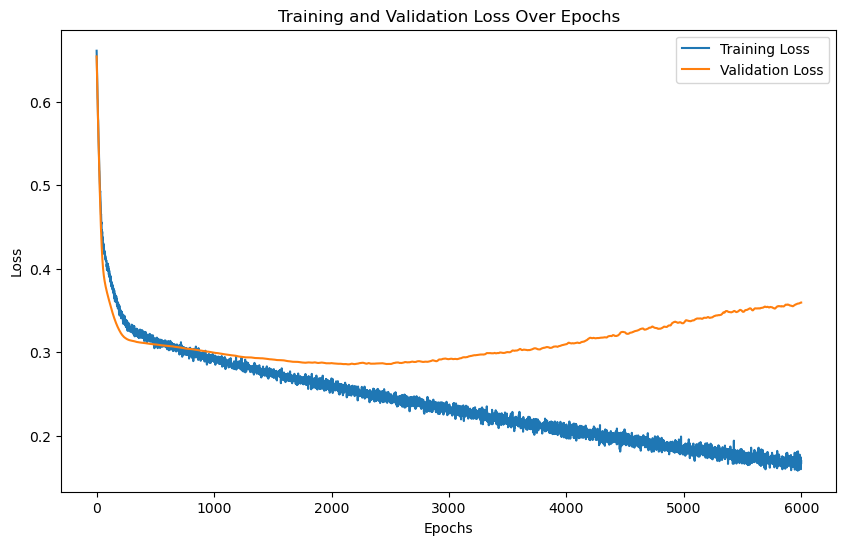

In [3]:
# Step 6: Plot the losses for Training and Validation data
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

The model seems to be driving training loss very low, but the validation loss increases further on. This suggest that our model is 'overtrained'. In a way, our model is memorizing the training data and choosing the weights to optimize the nuances in the training data, so when we apply these same model weights to a set that isn't exactly the same as the training set (in this case the validation set), our model starts to perform poorly. 

Let's run our second iteration of the model. The implementation will stay virtually the same as last time, except we will change some parameters (take away a layer) to prevent overfitting the model to the training data. The key attributes of this iteration is that the lambda value is 0.0001, there are 3 layers to the model, and we are running this on 6000 epochs.

In [13]:
# ----------------------------------------------MODEL ITERATION 2-----------------------------------------------------------

# Step 0: Import necessary libraries and modules

import pandas as pd # Import pandas library to load kaggle data into a pandas dataframe
import torch # Import pytorch for building and training the model
import torch.nn as nn # Import neural network module from PyTorch
import torch.optim as optimizer # Import optimization algorithms from Pytorch for backward pass
from sklearn.model_selection import train_test_split # Import test-train split feature
from sklearn.preprocessing import StandardScaler # Import feature scaling feature
from sklearn.metrics import accuracy_score, precision_score, recall_score # Import metrics
import matplotlib.pyplot as plt # Import matplotlib for graphing
import numpy as np

# Step 1: Load and Preprocess the data

# Load the dataset
file_path = '/mnt/c/Users/atrivedi/Downloads/archive/MBA.csv' # Local file path to dataset
df = pd.read_csv(file_path) # Read csv into pandas dataframe
df['admission'] = df['admission'].fillna(0)  # Assume NaN means 'Rejected' and fill with 0
df['race'] = df['race'].fillna('Unknown')  # Fill missing race with 'Unknown'


# Preprocess the dataset
df = pd.get_dummies(df, columns=['gender', 'international','race','major', 'work_industry'], drop_first=True) # Convert categorical (strings) variables into dummy (binary) variables so the neural net can work with it, not admission though
df['admission'] = df['admission'].apply(lambda x: 1 if x == 'Admit' else 0) # Convert 'Admit' to 1 and others to 0 for binary classification
X = df.drop('admission', axis=1) # Drop the admission column, so the features and the outputs aren't paired together
y = df['admission'] # Target variable
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split the data into training and test sets --> 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # Further split the training data into train and validation (to prevent manually tuning parameters to the output of the test data)
scaler = StandardScaler() # Create an instance of the StandardScaler class to scale our values
X_train = scaler.fit_transform(X_train) # Calculates the mean and standard deviation for each feature in the training dataset and then scales the training data based on these statistics.
X_val = scaler.transform(X_val) # Learns the scaling parameters from the training data and scales validation data
X_test = scaler.transform(X_test) # Learns the scaling parameters from the training data and scales test data
X_train_tensor = torch.FloatTensor(X_train)  # Convert training features to PyTorch tensor
X_val_tensor = torch.FloatTensor(X_val) # Convert validation features to PyTorch tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert test features to PyTorch tensor
y_train_tensor = torch.LongTensor(y_train.values)  # Convert training labels to LongTensor (for classification)
y_val_tensor = torch.LongTensor(y_val.values) # Convert validation labels to LongTensor
y_test_tensor = torch.LongTensor(y_test.values)  # Convert test labels to LongTensor

# Define MLP Model
class MLP(nn.Module): # Define a class for the MLP model, inheriting from the nn.Module framework
    def __init__(self, input_size): # Initialize the model with the input size
        """
        Initializes the MLP model with multiple fully connected layers.
        
        This model defines a neural network with three hidden layers, ReLU activation functions, 
        and dropout layers to prevent overfitting. The model is designed for binary classification 
        with two output neurons.
        
        Args:
            input_size (int): The number of input features (columns in the dataset).
        """
        super(MLP, self).__init__() # Allows MLP class to initialize any properties defined in nn.Module
        self.fc1 = nn.Linear(input_size, 128) # First layer with input size (based on columns of the df) and 256 neurons (output)
        self.fc2 = nn.Linear(128, 64) # Second layer with 256 input neurons and 128 output neurons
        self.fc3 = nn.Linear(64, 2)  # Output layer
        self.relu = nn.ReLU() # Initializes the ReLU activaton function to introduce non-linearity into the model
        self.dropout = nn.Dropout(p=0.5) # Add dropout
    def forward(self, x): # Define the forward pass 
        """
        Performs a forward pass through the network.
        
        The forward method takes in a tensor of input features, applies the linear transformations,
        ReLU activations, and dropout regularization, and outputs logits for each class.
        
        Args:
            x (torch.Tensor): Input tensor containing the features for each sample.
        
        Returns:
            torch.Tensor: The output logits for each class, before applying softmax or other post-processing.
        """
        x = self.relu(self.fc1(x)) # Apply the first layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.relu(self.fc2(x)) # Apply the second layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.fc3(x) # Pass through the output layer
        return x # Return the final output

# Step 3: Instantiate the model

input_size = X_train.shape[1] # Get the number of input features (columns of the df)
model = MLP(input_size) # Create an instance of the MLP model

# Step 4: Set up the loss function and optimizer

criterion = nn.CrossEntropyLoss() # Define the loss function
optimizer = optimizer.Adam(model.parameters(), lr=0.0001)  # Set up the Adam optimizer with a learning rate of 0.001 (this is useful for the backward pass)

# Step 5: Train the model
num_epochs = 6000 # Determine how many epochs of the model we want
train_losses = [] # List to store training losses
val_losses = [] # List to store validation losses
test_losses = [] # List to store test losses
for epoch in range(num_epochs): # Loop over each epoch
    model.train() # set the model to training mode
    optimizer.zero_grad()  # Clear gradients from the previous step
    outputs = model(X_train_tensor)  # Perform a forward pass to get model predictions
    loss = criterion(outputs, y_train_tensor)  # Compute the loss using the predictions and true labels
    loss.backward()  # Backpropagate the loss to compute gradients
    optimizer.step()  # Update model parameters based on computed gradients

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate the model on validation loss and test loss 
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        val_outputs = model(X_val_tensor)  # Forward pass on validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # Compute validation loss
        val_losses.append(val_loss.item())  # Store validation loss
        test_outputs = model(X_test_tensor)  # Forward pass on validation data
        test_loss = criterion(test_outputs, y_test_tensor)  # Compute validation loss
        test_losses.append(test_loss.item())  # Store validation loss

Once again, let's see the losses for our training and validation set to judge whether or not this model is 'optimized' and ready for test data to be run on it. Hopefully we made an improvement this time!

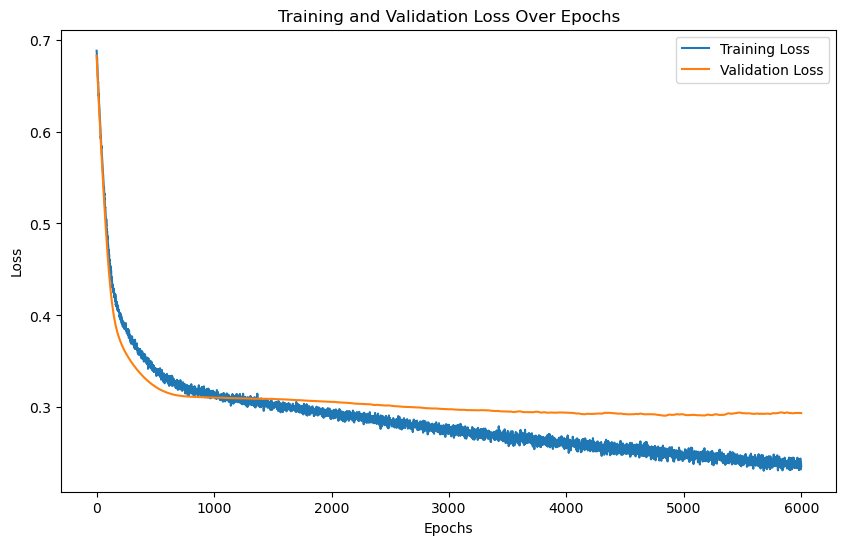

In [14]:
# Step 6: Plot the losses for Training and Validation data
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

Our model is less overtrained compared to the first iteration, but it could still be improved!

Let's run a third and final iteration. As with the prior iterations, the implementation will stay virtually the same as last time, except we will change some parameters (change the number of epochs from 6000 to 1000) to prevent overfitting the model to the training data. The key attributes of this iteration is that the lambda value is 0.0001, there are 3 layers to the model, and we are running this on 1000 epochs. Hopefully the third time is the charm!

In [2]:
# ----------------------------------------------MODEL ITERATION 3-----------------------------------------------------------

# Step 0: Import necessary libraries and modules

import pandas as pd # Import pandas library to load kaggle data into a pandas dataframe
import torch # Import pytorch for building and training the model
import torch.nn as nn # Import neural network module from PyTorch
import torch.optim as optimizer # Import optimization algorithms from Pytorch for backward pass
from sklearn.model_selection import train_test_split # Import test-train split feature
from sklearn.preprocessing import StandardScaler # Import feature scaling feature
from sklearn.metrics import accuracy_score, precision_score, recall_score # Import metrics
import matplotlib.pyplot as plt # Import matplotlib for graphing
import numpy as np

# Step 1: Load and Preprocess the data

# Load the dataset
file_path = '/mnt/c/Users/atrivedi/Downloads/archive/MBA.csv' # Local file path to dataset
df = pd.read_csv(file_path) # Read csv into pandas dataframe
df['admission'] = df['admission'].fillna(0)  # Assume NaN means 'Rejected' and fill with 0
df['race'] = df['race'].fillna('Unknown')  # Fill missing race with 'Unknown'


# Preprocess the dataset
df = pd.get_dummies(df, columns=['gender', 'international','race','major', 'work_industry'], drop_first=True) # Convert categorical (strings) variables into dummy (binary) variables so the neural net can work with it, not admission though
df['admission'] = df['admission'].apply(lambda x: 1 if x == 'Admit' else 0) # Convert 'Admit' to 1 and others to 0 for binary classification
X = df.drop('admission', axis=1) # Drop the admission column, so the features and the outputs aren't paired together
y = df['admission'] # Target variable
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split the data into training and test sets --> 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # Further split the training data into train and validation (to prevent manually tuning parameters to the output of the test data)
scaler = StandardScaler() # Create an instance of the StandardScaler class to scale our values
X_train = scaler.fit_transform(X_train) # Calculates the mean and standard deviation for each feature in the training dataset and then scales the training data based on these statistics.
X_val = scaler.transform(X_val) # Learns the scaling parameters from the training data and scales validation data
X_test = scaler.transform(X_test) # Learns the scaling parameters from the training data and scales test data
X_train_tensor = torch.FloatTensor(X_train)  # Convert training features to PyTorch tensor
X_val_tensor = torch.FloatTensor(X_val) # Convert validation features to PyTorch tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert test features to PyTorch tensor
y_train_tensor = torch.LongTensor(y_train.values)  # Convert training labels to LongTensor (for classification)
y_val_tensor = torch.LongTensor(y_val.values) # Convert validation labels to LongTensor
y_test_tensor = torch.LongTensor(y_test.values)  # Convert test labels to LongTensor

# Define MLP Model
class MLP(nn.Module): # Define a class for the MLP model, inheriting from the nn.Module framework
    def __init__(self, input_size): # Initialize the model with the input size
        """
        Initializes the MLP model with multiple fully connected layers.
        
        This model defines a neural network with three hidden layers, ReLU activation functions, 
        and dropout layers to prevent overfitting. The model is designed for binary classification 
        with two output neurons.
        
        Args:
            input_size (int): The number of input features (columns in the dataset).
        """
        super(MLP, self).__init__() # Allows MLP class to initialize any properties defined in nn.Module
        self.fc1 = nn.Linear(input_size, 128) # First layer with input size (based on columns of the df) and 256 neurons (output)
        self.fc2 = nn.Linear(128, 64) # Second layer with 256 input neurons and 128 output neurons
        self.fc3 = nn.Linear(64, 2)  # Output layer
        self.relu = nn.ReLU() # Initializes the ReLU activaton function to introduce non-linearity into the model
        self.dropout = nn.Dropout(p=0.5) # Add dropout
    def forward(self, x): # Define the forward pass 
        """
        Performs a forward pass through the network.
        
        The forward method takes in a tensor of input features, applies the linear transformations,
        ReLU activations, and dropout regularization, and outputs logits for each class.
        
        Args:
            x (torch.Tensor): Input tensor containing the features for each sample.
        
        Returns:
            torch.Tensor: The output logits for each class, before applying softmax or other post-processing.
        """
        x = self.relu(self.fc1(x)) # Apply the first layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.relu(self.fc2(x)) # Apply the second layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.fc3(x) # Pass through the output layer
        return x # Return the final output

# Step 3: Instantiate the model

input_size = X_train.shape[1] # Get the number of input features (columns of the df)
model = MLP(input_size) # Create an instance of the MLP model

# Step 4: Set up the loss function and optimizer

criterion = nn.CrossEntropyLoss() # Define the loss function
optimizer = optimizer.Adam(model.parameters(), lr=0.0001)  # Set up the Adam optimizer with a learning rate of 0.001 (this is useful for the backward pass)

# Step 5: Train the model
num_epochs = 1000 # Determine how many epochs of the model we want
train_losses = [] # List to store training losses
val_losses = [] # List to store validation losses
test_losses = [] # List to store test losses
for epoch in range(num_epochs): # Loop over each epoch
    model.train() # set the model to training mode
    optimizer.zero_grad()  # Clear gradients from the previous step
    outputs = model(X_train_tensor)  # Perform a forward pass to get model predictions
    loss = criterion(outputs, y_train_tensor)  # Compute the loss using the predictions and true labels
    loss.backward()  # Backpropagate the loss to compute gradients
    optimizer.step()  # Update model parameters based on computed gradients

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate the model on validation loss and test loss 
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        val_outputs = model(X_val_tensor)  # Forward pass on validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # Compute validation loss
        val_losses.append(val_loss.item())  # Store validation loss
        test_outputs = model(X_test_tensor)  # Forward pass on validation data
        test_loss = criterion(test_outputs, y_test_tensor)  # Compute validation loss
        test_losses.append(test_loss.item())  # Store validation loss

Will our training and validation losses be 'optimized' now. Let's see!

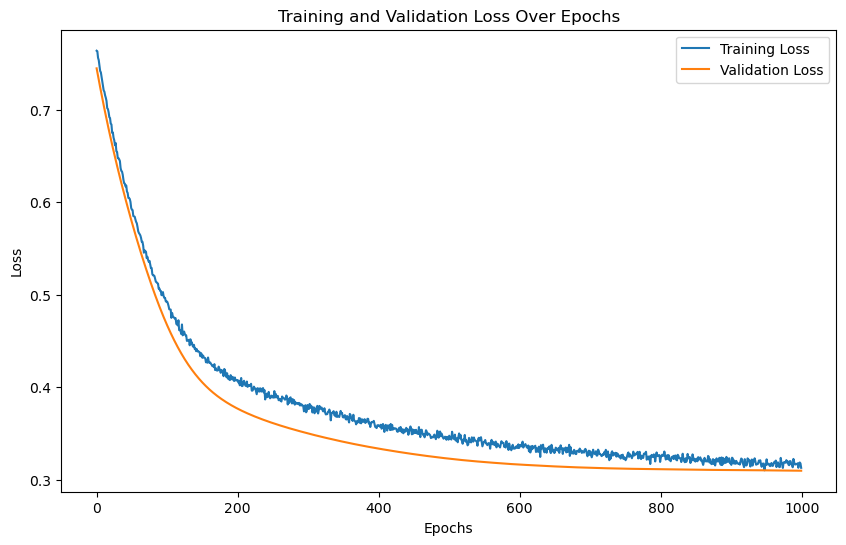

In [3]:
# Step 6: Plot the losses for Training and Validation data
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

While the training and validation loss for this set are not perfect, this version of our model is the best so far. I've actually ran a lot of differernt iteration of the model with different paramaters, and I found that this version is the best. We are going to use this 'optimized' version of the model to actually test our test data, and see if the model is as good as we hope.

To run our test data on the model to understand if our 'optimized' version of the model can perform well, we are going to create a confusion matrix and calculate its metrics.

Accuracy: 0.8483
Precision: 0.6111
Recall: 0.1122


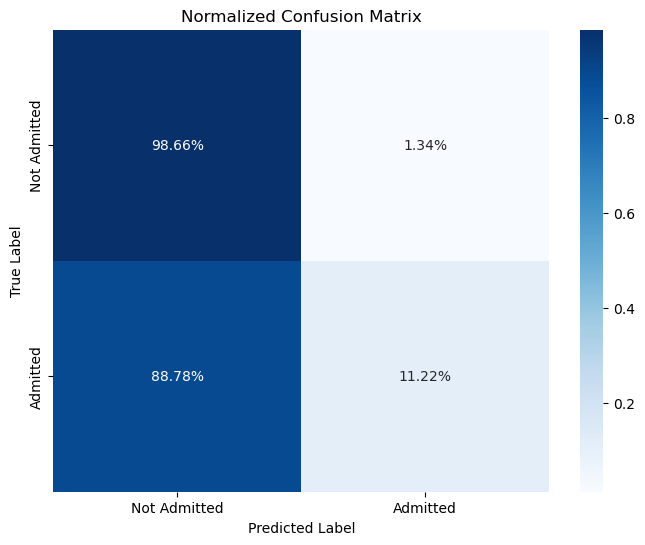

In [4]:
# Import necessary libraries for metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns 
import numpy as np

# After training your model, generate predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Forward pass on test data
    _, y_pred = torch.max(test_outputs, 1)  # Get the predicted class labels

# Convert tensors to numpy arrays for scikit-learn
y_test_np = y_test_tensor.numpy()  # True labels
y_pred_np = y_pred.numpy()  # Predicted labels

# Step 1: Create the confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convert to percentages

# Step 2: Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Step 3: Visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Not Admitted', 'Admitted'], 
            yticklabels=['Not Admitted', 'Admitted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()



The model is not performing as well as we wanted it to, but when we analyze why our model is underperforming, it makes sense. First off, we have a lot of unbalanced data in our dataset. By the nature of admission at UPenn Wharton's MBA program, they only accept 9% of applicants, so our dataset naturally contains more rejections than admissions. On top of this, at selective MBA programs, it is really easy to understand who won't get in. If an applicant has a low GPA, GMAT, or very little industry experience, they are likely to get rejected and it is easy to predict. But finding out who gets into the schools is a lot harder, since its left to the nuance of the admissions counselors reading their personal statements and letters of reconmendation (which our model does not consider). Just because a student has a 4.0 and high GMAT does not guarentee them admission, but having a low GPA can certainly guarentee rejection. These ideas can be seen in our metric calculations. We have a really high accuracy rate, which shows the proportion of correctly classified instances (both true positives and true negatives) out of all instances. In our case, our model is really good at predicting rejections. Our recall (the proportion of actual positives that are correctly identified) is really low (0.1122), which makes sense since it is hard to understand who is getting into Wharton, no matter their portfolio. This model, in its current state could be used to help set realistic expectations for lower quality applications to Wharton, and predict their rejection. It could not actually be implemented for admissions decisions.



Lets look at a reciever operating characterstic curve as our last visual to get a glance of our model performance from a different angle. Even though our model isn't performing as well as we wanted, the ROC curve will show how our model has a relatively strong ability to separate the positive class (admitted applicants) from the negative class (non-admitted applicants).

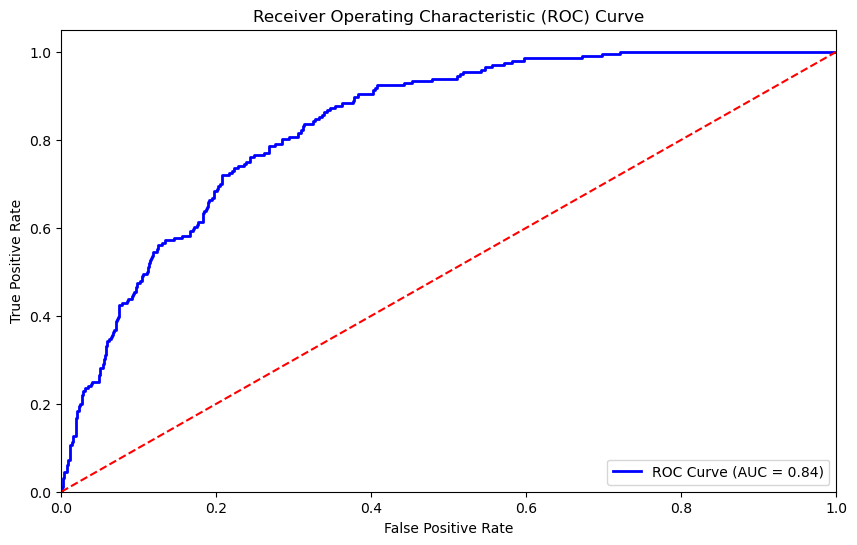

In [7]:
from sklearn.metrics import roc_curve, auc
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Forward pass on test data
    probabilities = nn.Softmax(dim=1)(test_outputs)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, probabilities)  # y_test should be the actual labels
roc_auc = auc(fpr, tpr)  # Calculate the AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


An ideal ROC curve would look like an upside down L, showing that the model distinguishes every true positive and false positive case, and would have an AUC (area under the curve) of 1. We have an AUC of 0.84, which is still pretty good (not what we want though). An AUC of 0.84 means that if we were to randomly pick one applicant who got admitted and one who didn’t, our model has an 84% chance of correctly predicting that the admitted applicant has a higher probability of admission than the non-admitted one. To put it simply, our model is 84% likely to rank admitted applicants above non-admitted applicants based on its predictions. 

To answer our guiding question on if it is feasible to classify who gets into the University of Pennsylvania's Wharton MBA program based on quantifiable parts of an applicants application, it's pretty clear that the answer is no. This notebook gives us a clear example on how trying fit a model on a problem that has subjective elements to it isn't the best choice. If I were to go forward with this project, I'd want to run topic modeling algorithms on applicants essays to see if we could gauge whether certain essays have higher choices of getting into Wharton.